# CSCI316 Group Assignment 1
# Task 1
# Group: G18

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn jupyter


In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_theme()
pd.set_option("display.max_columns", None)


In [ ]:
CSV_PATH = "apartments_for_rent_classified_10K.csv"  

df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r"\s+", "_", regex=True))
df.drop(columns=["price_display"], errors="ignore", inplace=True)

def _extract_price(series):
    if series is None: 
        return pd.Series([np.nan]*len(df))
    return (series.astype(str)
             .str.replace(",", "", regex=False)
             .str.extract(r"(\d{3,6})")[0]
             .astype("float64"))

if "price" not in df.columns:
    cand = None
    for col in ["title","body"]:
        if col in df.columns:
            tmp = _extract_price(df[col])
            if tmp.notna().sum() > 0:
                cand = tmp; break
    if cand is None:
        raise ValueError("No 'price' column and could not extract it from the dataset.")
    df["price"] = cand

df = df[pd.to_numeric(df["price"], errors="coerce").notna()].copy()
df["price"] = df["price"].astype(float)
df = df[(df["price"]>=100) & (df["price"]<=20000)].copy()
print(df.shape); df[["price"]].describe()


(9998, 21)


,price
count,9998.000000
mean,1478.823265
std,918.379816
min,200.000000
25%,949.000000
50%,1270.000000
75%,1695.000000
max,19500.000000


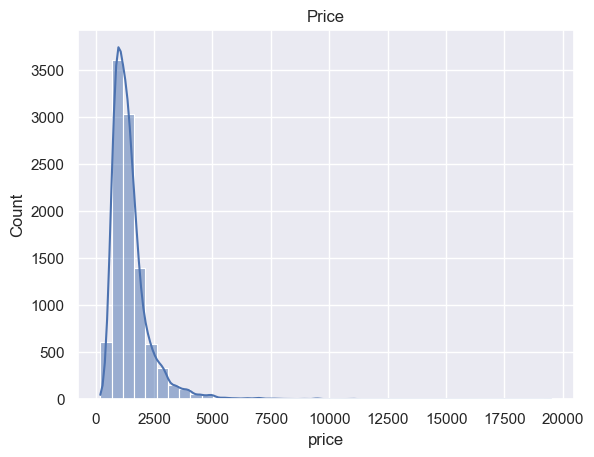

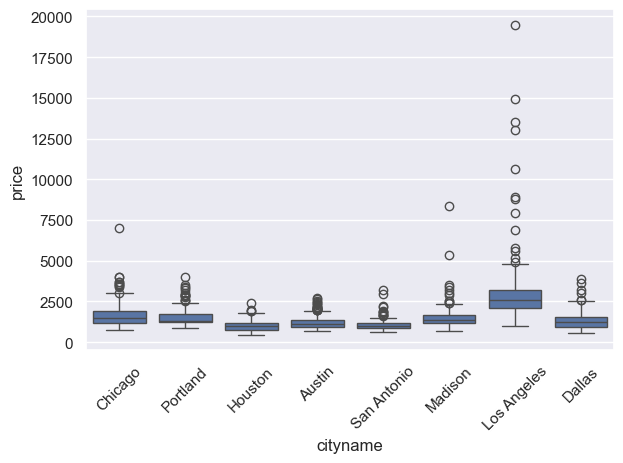

In [3]:
sns.histplot(df["price"], bins=40, kde=True); plt.title("Price"); plt.show()
if "cityname" in df.columns:
    top = df["cityname"].value_counts().head(8).index
    sns.boxplot(x="cityname", y="price", data=df[df["cityname"].isin(top)])
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [4]:
class AddCustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True): self.add_features = add_features
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        if not self.add_features: 
            return X
        if {"bedrooms","bathrooms"}.issubset(X.columns):
            X["bed_bath_ratio"] = X["bedrooms"] / (X["bathrooms"].replace(0, np.nan) + 1e-6)
        if "amenities" in X.columns:
            X["amenity_count"] = X["amenities"].fillna("").astype(str).str.count(",") + (X["amenities"].notna()).astype(int)
        if "title" in X.columns: X["title_len"] = X["title"].fillna("").astype(str).str.len()
        if "body"  in X.columns: X["body_len"]  = X["body"].fillna("").astype(str).str.len()
        if "square_feet" in X.columns:
            X["log_square_feet"] = np.log1p(pd.to_numeric(X["square_feet"], errors="coerce"))
        return X

class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): self.preprocessor_ = None
    def fit(self, X, y=None):
        num = X.select_dtypes(include=[np.number]).columns.tolist()
        cat = [c for c in X.columns if c not in num]
        num_tf = Pipeline([("imputer", SimpleImputer(strategy="median")),
                           ("scaler", StandardScaler())])
        cat_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                           ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        self.preprocessor_ = ColumnTransformer([("num", num_tf, num), ("cat", cat_tf, cat)])
        self.preprocessor_.fit(X, y)
        return self
    def transform(self, X):
        return self.preprocessor_.transform(X)


In [5]:
drop_cols = ["id","source","price_display"]
use_cols = [c for c in df.columns if c not in drop_cols]
X = df[use_cols].copy()
y = df["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
def make_pipe(model):
    return Pipeline([
        ("features", AddCustomFeatures()),  # tuned via features__add_features
        ("prep", DynamicPreprocessor()),
        ("model", model)
    ])

pipes = {
    "LinearRegression": make_pipe(LinearRegression()),
    "RandomForest":     make_pipe(RandomForestRegressor(random_state=42, n_jobs=-1)),
    "GradientBoosting": make_pipe(GradientBoostingRegressor(random_state=42)),
}


In [10]:
search_space_rf = {
    "features__add_features": [True, False],
    "model__n_estimators": [150, 250, 350],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 2, 5],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5],
}

tuned = {}

rs = RandomizedSearchCV(
    pipes["RandomForest"],                 # only the RF pipeline
    param_distributions=search_space_rf,
    n_iter=15,                              # number of random combos to try
    cv=3,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    verbose=1
)

rs.fit(X_train, y_train)
tuned["RandomForest"] = rs

print(
    "RandomForest best params:",
    rs.best_params_,
    "CV best RMSE:",
    -rs.best_score_
)



Fitting 3 folds for each of 15 candidates, totalling 45 fits
RandomForest best params: {'model__n_estimators': 150, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 20, 'features__add_features': True} CV best RMSE: 151.9079047364107


,MAE,RMSE,R2
RandomForest,13.14184,92.685974,0.989517


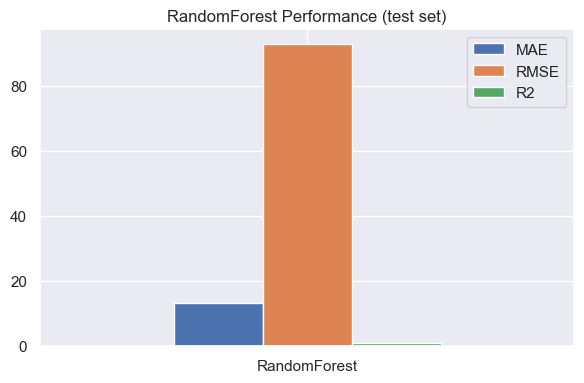

In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Only evaluate RandomForest
results = {}

rf_rs = tuned["RandomForest"]               # get the RandomForest search result
best_rf = rf_rs.best_estimator_              # best tuned pipeline
pred = best_rf.predict(X_test)

mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)                          # compute RMSE manually

results["RandomForest"] = {
    "MAE":  mean_absolute_error(y_test, pred),
    "RMSE": rmse,
    "R2":   r2_score(y_test, pred)
}

results_df = pd.DataFrame(results).T
display(results_df)

# Plot only RandomForest scores
ax = results_df[["MAE", "RMSE", "R2"]].plot(kind="bar", figsize=(6,4))
plt.title("RandomForest Performance (test set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
